In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import mahotas as mt
from matplotlib import pyplot as plt
from skimage import exposure

%matplotlib inline

In [2]:
train = "./train"
img_folders = os.listdir(train)

In [3]:
print(len(img_folders))
print('Folders: ', img_folders)

38
Folders:  ['Tomato___Spider_mites Two-spotted_spider_mite', 'Squash___Powdery_mildew', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Target_Spot', 'Tomato___Septoria_leaf_spot', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Cherry_(including_sour)___healthy', 'Pepper,_bell___Bacterial_spot', 'Grape___healthy', 'Pepper,_bell___healthy', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Apple___Apple_scab', 'Blueberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Potato___healthy', 'Soybean___healthy', 'Strawberry___healthy', 'Apple___healthy', 'Peach___healthy', 'Potato___Early_blight', 'Apple___Cedar_apple_rust', 'Tomato___Bacterial_spot', 'Grape___Black_rot', 'Peach___Bacterial_spot', 'Corn_(maize)___Northern_Leaf_Blight', 'Cherry_(including_sour)___Powdery_mildew', 'Potato___Late_blight', 'Grape___Esc

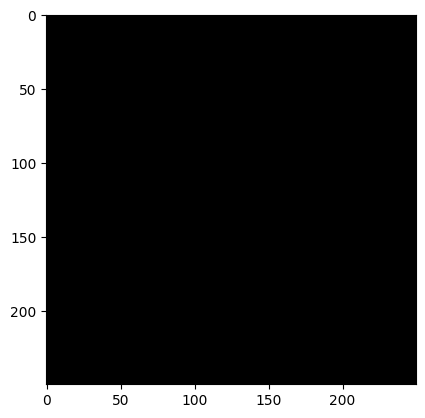

In [4]:
# get a black image
black_img = np.empty([250, 250, 3], dtype=np.uint8)
black_img.fill(0)
plt.imshow(black_img, cmap="Greys_r")

In [5]:
def create_dataset():
    names = ['mean_r', 'mean_g', 'mean_b',
             'stddev_r', 'stddev_g', 'stddev_b',
             'contrast', 'correlation', 'inverse_difference_moments', 'entropy',
             'y'
             ]
    df = pd.DataFrame([], columns=names)

    count = 0

    for folder in img_folders:
        img_files = os.listdir(path='./train/'+folder)
        for index, img_file in enumerate(img_files):
            if index > 200:
                break

            img_path = "./train/" + folder + '/' + img_file
            main_img = cv2.imread(img_path)

            if main_img is None:
                print(f"Error reading image: {img_path}")
                continue

            # Preprocessing
            img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (400, 300))

            gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            # Applying CLAHE (Contrast Limited Adaptive Histogram Equalization)
            clahe = exposure.equalize_adapthist(
                gs, kernel_size=None, clip_limit=0.015, nbins=256)

            # Convert the float64 image to 8-bit
            clahe_uint8 = (clahe * 255).astype(np.uint8)

            # Adjusting contrast in the enhanced image
            contrasted_image = np.clip(clahe_uint8, 0, 255)

            blur = cv2.GaussianBlur(contrasted_image, (35, 35), 0)

            return_otsu_threshould, im_bw_otsu = cv2.threshold(
                blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

            kernel = np.ones((35, 35), np.uint8)
            closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)

            # Contour
            contours, hierarchy = cv2.findContours(
                closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            # Finding the correct leaf contour from the list of contours
            def find_contour(cnts):
                contains = []
                y_ri, x_ri, _ = img.shape
                for cc in cnts:
                    yn = cv2.pointPolygonTest(cc, (x_ri//2, y_ri//2), False)
                    contains.append(yn)

                val = [contains.index(temp) for temp in contains if temp > 0]
                if len(val) < 1:
                    return -1

                return val[0]

            index = find_contour(contours)
            if index == -1:
                continue

            cnt = contours[index]

            # Create a black image to draw contours
            black_img = np.zeros_like(img)

            # Draw contour on the black image
            mask = cv2.drawContours(black_img, [cnt], 0, (255, 255, 255), -1)
            img = cv2.bitwise_and(img, mask)

            # Color features
            red_channel = img[:, :, 0]
            green_channel = img[:, :, 1]
            blue_channel = img[:, :, 2]

            blue_channel[blue_channel == 255] = 0
            green_channel[green_channel == 255] = 0
            red_channel[red_channel == 255] = 0

            # calculating the statistical values of all channels
            red_mean = np.mean(red_channel)
            green_mean = np.mean(green_channel)
            blue_mean = np.mean(blue_channel)

            red_std = np.std(red_channel)
            green_std = np.std(green_channel)
            blue_std = np.std(blue_channel)

            # Texture features
            textures = mt.features.haralick(gs)
            ht_mean = textures.mean(axis=0)
            contrast = ht_mean[1]
            correlation = ht_mean[2]
            inverse_diff_moments = ht_mean[4]
            entropy = ht_mean[8]

            # Define vector inside the loop
            vector = [red_mean, green_mean, blue_mean,
                      red_std, green_std, blue_std,
                      contrast, correlation, inverse_diff_moments, entropy, count]

            df_temp = pd.DataFrame([vector], columns=names)
            if not df_temp.empty:
                df = pd.concat([df, pd.DataFrame(df_temp)], ignore_index=True)
            # print(img_file)
        count += 1
    return df

In [6]:
dataset = create_dataset()

/tmp/ipykernel_60638/487735315.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(df_temp)], ignore_index=True)


In [7]:
dataset.shape

(7638, 11)

In [8]:
type(dataset)

pandas.core.frame.DataFrame

In [9]:
dataset.to_csv("plant_village_200_400-300-v2.csv")

In [ ]:
def remove_bg(main_img):
    # Preprocessing
    img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (250, 250))

    gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Applying CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = exposure.equalize_adapthist(
        gs, kernel_size=None, clip_limit=0.015, nbins=256)

    # Convert the float64 image to 8-bit
    clahe_uint8 = (clahe * 255).astype(np.uint8)

    # Adjusting contrast in the enhanced image
    contrasted_image = np.clip(clahe_uint8, 0, 255)

    blur = cv2.GaussianBlur(contrasted_image, (35, 35), 0)

    return_otsu_threshould, im_bw_otsu = cv2.threshold(
        blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    kernel = np.ones((35, 35), np.uint8)
    closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
    # Contour
    contours, hierarchy = cv2.findContours(
        closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Finding the correct leaf contour from the list of contours

    def find_contour(cnts):
        contains = []
        y_ri, x_ri, _ = img.shape
        for cc in cnts:
            yn = cv2.pointPolygonTest(cc, (x_ri//2, y_ri//2), False)
            contains.append(yn)
            val = [contains.index(temp) for temp in contains if temp > 0]
            if len(val) < 1:
                return -1
        return val[0]

    index = find_contour(contours)

    if index == -1:
        return

    cnt = contours[index]
    # Create a black image to draw contours
    black_img = np.zeros_like(img)
    # Draw contour on the black image
    mask = cv2.drawContours(black_img, [cnt], 0, (255, 255, 255), -1)
    img = cv2.bitwise_and(img, mask)